In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image

import cv2  

In [2]:
project_path = '.'
RANDOM_STATE = 86
ORIGINAL_IMG_SIZE = (224, 224) # width and height

STABLE_HEIGHT = 'stable_height'

In [4]:
def get_label_df(data_split):
	return pd.read_csv(f'COMP90086_2024_Project_{data_split}/{data_split}.csv')

label_dfs_before_split = {data_split:get_label_df(data_split) for data_split in ['train', 'test']}

class_counts = label_dfs_before_split['train']['instability_type'].value_counts()
print(f'{STABLE_HEIGHT} train distribution: {class_counts / sum(class_counts)}')

stable_height train distribution: instability_type
1    0.50
0    0.25
2    0.25
Name: count, dtype: float64


# Retrieve Data

In [5]:
# centralize object during training/inferencing, for images with background removed only as it assumes the background is black pixels
def centralize_object(image):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # Background is black

	# Find contours in the thresholded image
	contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	
	centered_img = image
	# Assuming the largest contour is the object of interest
	if contours:
		target_size = (150, 150)
		new_object_h = 130
		largest_contour = max(contours, key=cv2.contourArea)
	
		# Get the bounding box of the largest contour
		x, y, w, h = cv2.boundingRect(largest_contour)
	
		# Crop the object from the original image
		cropped_object = image[y:y+h, x:x+w]
	
		aspect_ratio = w / h
		new_object_w = int(new_object_h * aspect_ratio)

		if new_object_w > 130:
			new_object_w = 130
			new_object_h = int(new_object_w / aspect_ratio)

		resized_object = cv2.resize(cropped_object, (new_object_w, new_object_h))
	
		# Create a new black image
		centered_img = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
	
		# Calculate center position to place the resized object
		center_x = (target_size[0] - resized_object.shape[1]) // 2
		center_y = (target_size[1] - resized_object.shape[0]) // 2
	
		# Place the resized object in the center of the new image
		centered_img[center_y:center_y + resized_object.shape[0], center_x:center_x + resized_object.shape[1]] = resized_object
	
	return centered_img

def centralize_object_old(image):
	# Convert to grayscale (assuming the object is in non-black pixels)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	
	# Find all non-black pixels (object area)
	non_zero_coords = cv2.findNonZero(gray)

	# Get the bounding box of the non-black pixels
	x, y, w, h = cv2.boundingRect(non_zero_coords)
	
	# Crop the object from the image
	cropped_obj = image[y:y+h, x:x+w]
	
	# Create a new black image of the same size
	centered_img = np.zeros_like(image)
	
	# Calculate the coordinates where the object should be placed to be centralized
	center_x = (224 - w) // 2
	center_y = (224 - h) // 2
	
	# Place the cropped object in the center of the new image
	centered_img[center_y:center_y+h, center_x:center_x+w] = cropped_obj
	
	return centered_img

def get_label(label_df, img_id):
	img_record = label_df.loc[label_df['id'] == img_id]
	if not img_record.empty:
		if STABLE_HEIGHT in img_record.columns:
			return int(img_record[STABLE_HEIGHT].values[0]) - 1
		else: 
			print(img_id, img_record)
			raise KeyError(f"Required columns '{STABLE_HEIGHT}' is missing in the DataFrame.")
	else:
		raise ValueError(f"Image ID {img_id} not found in the DataFrame.")

def get_image(data_split, img_id, size=ORIGINAL_IMG_SIZE, img_type = None): 
	img_folder = data_split if data_split != 'dev' else 'train'
	img_type = img_folder if img_type is None else img_type
	img_path = os.path.join(project_path, f'COMP90086_2024_Project_{img_folder}/{img_type}', f'{img_id}.jpg')
	img = image.load_img(img_path, target_size=size)

	return img

def get_sample(label_dfs, data_split, img_id, size=ORIGINAL_IMG_SIZE, img_type = None): 
	img = get_image(data_split, img_id, size, img_type)
	label = get_label(label_dfs[data_split], img_id)

	return img, label

def show_img(img): 
	plt.imshow(img)
	plt.axis('off')
	plt.show()
	

In [6]:
print(label_dfs_before_split['train'].shape)
label_dfs_before_split['train'].head()

(7680, 7)


,id,shapeset,type,total_height,instability_type,cam_angle,stable_height
0,54,2,1,3,1,1,2
1,173,1,1,4,1,2,1
2,245,1,1,4,1,2,1
3,465,2,1,5,0,1,5
4,611,2,1,3,1,1,1


Class: 0


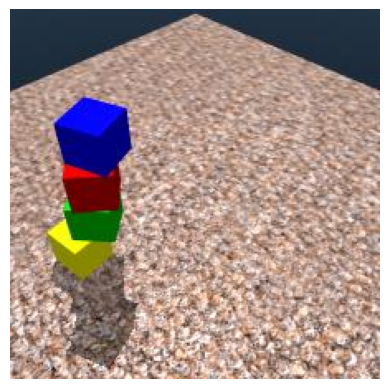

In [7]:
img, label = get_sample(label_dfs_before_split, 'train', 173)
print('Class:', label)
show_img(img)

# Data Augmentation

## Background Removal

In [ ]:
# May use google colab for this process to avoid dependency conflict issues

import rembg
import numpy as np
from PIL import Image

# Load the input image

def rm_background(image_path):
	input_image = Image.open(image_path)

	# Convert the input image to a numpy array
	input_array = np.array(input_image)

	# Apply background removal using rembg
	output_array = rembg.remove(input_array)

	# Create a PIL Image from the output array
	output_image = Image.fromarray(output_array)
	if output_image.mode == 'RGBA':
		output_image = output_image.convert('RGB')
	return output_image

# uncomment below to generate background removed samples
""" 
from tqdm import tqdm
# Path to the original and augmented image folders
input_folder = 'train' # or 'test' for testing dataset
output_folder = 'train_rm_background' # or 'test_rm_background' for testing dataset

# Create the output folder if it doesn't exist
if not os.path.exists(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder)):
	os.makedirs(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder))

# Loop through all the images in the input folder
for filename in tqdm(os.listdir(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', input_folder))):
	if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
		# Load the image
		img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', input_folder, filename)
		image_bremoved = rm_background(img_path)
		augment_img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder, filename)
		# Save the output image as JPEG
		image_bremoved.save(augment_img_path)


print(f"All images have been augmented and saved in '{output_folder}' folder.")
 """

## Background Removal Refined

In [ ]:
def rm_background_refined():
	input_folder = 'train' # or 'test'
	base_img_folder = input_folder + '_rm_background' # or e.g. 'test' / 'test_rm_background'
	output_folder = input_folder + '_rm_background_refined'

	# Create the output folder if it doesn't exist
	if not os.path.exists(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder)):
			os.makedirs(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder))  

	changed_images_num = 0
	# Loop through all the images in the input folder
	for filename in os.listdir(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', base_img_folder)):
		if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
			# Load the image
			img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', base_img_folder, filename)
			image = cv2.imread(img_path)  
			image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

			# Remove wood floor background
			hue_channel = image_hsv[:, :, 0]
			mask = cv2.inRange(hue_channel, 0, 20)
			mask_inv = cv2.bitwise_not(mask) 
			processed_image = cv2.bitwise_and(image, image, mask=mask_inv)
		
			# Remove white background
			# sat_channel = processed_image[:, :, 1]
			# print(sat_channel[100, 100])
			# mask = cv2.inRange(sat_channel, 150, 255)
			# mask_inv = cv2.bitwise_not(mask)
			# processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask_inv) 

			difference = cv2.absdiff(image, processed_image)
			changed_pixels = np.count_nonzero(difference)

			saved_image = image

			# The change is significant
			if changed_pixels > 1500:
				changed_images_num += 1
				saved_image = processed_image
				
				image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
				processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
				
				show_diff = False
				if show_diff:
					plt.figure(figsize=(8, 8))
					plt.tight_layout()
					plt.subplot(1, 2, 1)
					plt.imshow(image_rgb)
					plt.title('Original')
					plt.axis('off')
					
					plt.subplot(1, 2, 2)
					plt.imshow(processed_image_rgb)
					plt.title('Processed')
					plt.axis('off')
					
					plt.show()

			# Save the image in the output folder
			augment_img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder, filename)
			cv2.imwrite(augment_img_path, saved_image)
	print(f"All images have been refined and saved in '{output_folder}' folder, changed images count: {changed_images_num}") 

rm_background_refined()

In [8]:
import random
def randomize_colors(image):
	# Convert to HSV (Hue, Saturation, Value) color space
	hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

	# Randomly modify hue, saturation, and brightness
	hue_shift = random.randint(-5, 5)
	saturation_shift = random.uniform(0.5, 1.5)
	brightness_shift = random.uniform(0.5, 1.5)

	# Apply shifts
	hsv_image[:, :, 0] = (hsv_image[:, :, 0] + hue_shift) % 180
	hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_shift, 0, 255)
	hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_shift, 0, 255)

	# Convert back to BGR color space
	return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def random_aspect_ratio(image, min_aspect_ratio=0.75, max_aspect_ratio=1.25):
	height, width = image.shape[:2]
	aspect_ratio = random.uniform(min_aspect_ratio, max_aspect_ratio)

	# Adjust the width or height based on aspect ratio
	if aspect_ratio > 1:
		new_width = int(width * aspect_ratio)
		new_height = height
	else:
		new_width = width
		new_height = int(height / aspect_ratio)
	
	# Resize the image
	resized_image = cv2.resize(image, (new_width, new_height))

	# Crop the image to the original size
	x_start = (new_width - width) // 2
	y_start = (new_height - height) // 2
	cropped_image = resized_image[y_start:y_start + height, x_start:x_start + width]

	return cropped_image

def random_rotation(image, min_angle=-10, max_angle=10):
	height, width = image.shape[:2]
	
	# Randomly select a small angle
	angle = random.uniform(min_angle, max_angle)
	
	# Get the rotation matrix for the center of the image
	rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1.0)
	
	# Rotate the image using the transformation matrix
	rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC)
	
	return rotated_image


from skimage import segmentation, color
def blur_background(image): 
	image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	labels = segmentation.slic(image_rgb, compactness=30, n_segments=400)
	result = color.label2rgb(labels, image_rgb, kind='avg')
	result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
	return result


def apply_canny_edge_detection(img_array):
	# Convert to grayscale if it's a color image
	if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB image
		gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
	else:
		gray = img_array
	
	# Ensure the grayscale image is of type np.uint8
	if gray.dtype != np.uint8:
		gray = cv2.convertScaleAbs(gray)
	
	# Apply Canny edge detection
	edges =cv2.Canny(gray, 90, 150)  # Thresholds can be adjusted
	
	# Convert edges to RGB for visualization
	edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
	
	return edges_rgb

Running the following block creates different offline-augmented images, saved to output_folder newly created in COMP90086_2024_Project_train/test based on the input_folder

In [9]:
gen_data_augmentation = True

if gen_data_augmentation:
	# Path to the original and augmented image folders
	input_folder = 'train' # or 'test'
	base_img_folder = 'train_rm_background' # or e.g. 'test' / 'test_rm_background'
	
	train_augmentations = [base_img_folder] + ['train_rm_background_flipped', 'train_rm_background_aspect_ratio', 'train_rm_background_color', 'train_rm_background_rotation']
	for train_augmentation in train_augmentations:
		output_folder = train_augmentation
		if train_augmentation == base_img_folder:
			output_folder = base_img_folder + '_centralized'

		# Create the output folder if it doesn't exist
		if not os.path.exists(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder)):
			os.makedirs(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder))

		# Loop through all the images in the input folder
		for filename in os.listdir(os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', base_img_folder)):
			if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
				# Load the image
				img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', base_img_folder, filename)
				augment_image = cv2.imread(img_path)

				# The method to augment the image
				if train_augmentation == 'train_rm_background_flipped':
					augment_image = cv2.flip(augment_image, 1) # horizontal flip
				elif train_augmentation == 'train_rm_background_color':
					augment_image = randomize_colors(augment_image)
				elif train_augmentation == 'train_rm_background_aspect_ratio':
					augment_image = random_aspect_ratio(augment_image)
				elif train_augmentation == 'train_rm_background_rotation':
					augment_image = random_rotation(augment_image)

				augment_image = centralize_object_old(augment_image)
				# augment_image = blur_background(image_) # not applied to images with background removed

				# Save the augmented image in the output folder
				augment_img_path = os.path.join(project_path, f'COMP90086_2024_Project_{input_folder}', output_folder, filename)
				cv2.imwrite(augment_img_path, augment_image)
				
		print(f"All images have been augmented and saved in '{output_folder}' folder.")


All images have been augmented and saved in 'train_rm_background_centralized' folder.
All images have been augmented and saved in 'train_rm_background_flipped' folder.
All images have been augmented and saved in 'train_rm_background_aspect_ratio' folder.
All images have been augmented and saved in 'train_rm_background_color' folder.
All images have been augmented and saved in 'train_rm_background_rotation' folder.
